# CNN network

### Importing the necessary libraries

In [ ]:
import sys
import torch
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import time
import matplotlib.pyplot as plt
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')


# np.random.seed(1234)

Mounted at /content/drive


In [ ]:
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform
import torchvision
import PIL

In [ ]:
Values = np.loadtxt("/content/drive/MyDrive/24787ProjectDocuments/7yearsO3/Values.txt", delimiter=' ')
Coordinates = np.loadtxt("/content/drive/MyDrive/24787ProjectDocuments/7yearsO3/Coordinates.txt", delimiter=' ')
a = 575 # pitts 的位置

print(Values.shape)
print(Coordinates.shape)


(626, 2557)
(626, 2)


In [ ]:
target_value = Values[a,:].flatten()
target_value = target_value[3:2557]
print(target_value.shape)

(2554,)


In [ ]:
cord=np.delete(Coordinates,a,axis=0)-Coordinates[a]
valu=np.delete(Values,a,axis=0)
# one_day=valu[:,0]
# a=np.hstack((cord,one_day))

# min=np.array([np.min(cord[:,0]),np.min(cord[:,1])])
# max=np.array([np.max(cord[:,0]),np.max(cord[:,1])])
# x=np.linspace(min[0],max[0],num=20)
# y=np.linspace(min[1],max[1],num=20)
# xx,yy=np.meshgrid(x,y)
# xy_flat=np.hstack(xx.reshape(-1,1),yy.reshape(-1,1))
# average=[]
# for i in range(len(x)):
#   for j in range(len(y)):
#     for k in range(cord.shape[0]):
#       if (cord[k,0])

# label = Values[a].T.reshape(2557,1)
print(np.max(valu))


0.139


In [ ]:
min=np.array([np.min(cord[:,0]),np.min(cord[:,1])])
max=np.array([np.max(cord[:,0]),np.max(cord[:,1])])

# Reshape and average the data in the same cell within the 2d map
value=valu
for i in range(40):
  for j in range(50):
    mean=[]
    for k in range(625):
      x=int((cord[k,0]-min[0])/(max[0]-min[0])*40)
      y=int((cord[k,1]-min[1])/(max[1]-min[1])*50)
      if (x==i&y==j):
        mean.append(k)
    if (len(mean)!=0):
      average_val=np.mean(valu[mean,:],axis=0)
      value[mean,:]=np.tile(average_val,(len(mean),1))




In [ ]:
print(np.isnan(value))

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


In [ ]:
import cv2
from google.colab.patches import cv2_imshow

for m in range(2557):
  p=np.zeros((40,50))
  b=np.hstack((cord,value[:,m][:,None]))
  for i in b:
    x=int((i[0]-min[0])/(max[0]-min[0])*39)
    y=int((i[1]-min[1])/(max[1]-min[1])*49)
    z=i[2]/(np.max(value)-np.min(value))*255
    p[x,y]=z
  cv2.imwrite(f"/content/drive/MyDrive/24787ProjectDocuments/dataPng/{m}.png", p)

In [ ]:
### Initiate GPU

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


In [ ]:
for i in range(64):
  img_name = f"/content/drive/MyDrive/24787ProjectDocuments/dataPng/{i}.png"
  image = io.imread(img_name)
  image = np.stack((image,)*3, axis=-1)
  image = torchvision.transforms.ToTensor()(image)
  label = torch.tensor(target_value[i])
  image = transform(image)

In [ ]:
idx=1
img_name1 = f"/content/drive/MyDrive/24787ProjectDocuments/dataPng/{idx}.png"
img_name2 = f"/content/drive/MyDrive/24787ProjectDocuments/dataPng/{idx+1}.png"
img_name3 = f"/content/drive/MyDrive/24787ProjectDocuments/dataPng/{idx+2}.png"
image1 = io.imread(img_name1)
image2 = io.imread(img_name2)
image3 = io.imread(img_name3)
image = np.stack((image1,)*3, axis=-1)
print(image.shape)

(40, 50, 3)


In [ ]:
class CustomDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, length, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        # self.landmarks_frame = pd.read_csv(csv_file)
        # self.root_dir = root_dir
        self.transform = transform
        self.length = length

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name1 = f"/content/drive/MyDrive/24787ProjectDocuments/dataPng/{idx}.png"
        img_name2 = f"/content/drive/MyDrive/24787ProjectDocuments/dataPng/{idx+1}.png"
        img_name3 = f"/content/drive/MyDrive/24787ProjectDocuments/dataPng/{idx+2}.png"
        image1 = io.imread(img_name1)
        image2 = io.imread(img_name2)
        image3 = io.imread(img_name3)
        image = np.stack((image1,image2,image3), axis=-1)
        # image = PIL.Image.open(img_name)
        # image = image.convert('RGB')
        image = torchvision.transforms.ToTensor()(image)
        # print(stacked_img)
        
        label = torch.tensor(target_value[idx])

        if self.transform:
            image = self.transform(image)
        # print(image.shape)
        return image, label

In [ ]:
transform = torch.nn.Sequential(
    # ,
    torchvision.transforms.Resize((244,244)),
    # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
)

In [ ]:
from torch.utils.data import DataLoader

whole_data = CustomDataset(2554,transform=transform)

train_set, val_set = torch.utils.data.random_split(whole_data, [2000, 554])


train_loader = DataLoader(train_set, batch_size=1, shuffle=True,num_workers=0)
test_loader = DataLoader(val_set, batch_size=1, shuffle=True,num_workers=0)

In [ ]:
next(iter(train_loader))


[tensor([[[[0.1216, 0.1216, 0.1201,  ..., 0.0000, 0.0000, 0.0000],
           [0.1216, 0.1216, 0.1201,  ..., 0.0000, 0.0000, 0.0000],
           [0.1216, 0.1216, 0.1201,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
          [[0.1569, 0.1569, 0.1549,  ..., 0.0000, 0.0000, 0.0000],
           [0.1569, 0.1569, 0.1549,  ..., 0.0000, 0.0000, 0.0000],
           [0.1569, 0.1569, 0.1549,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
          [[0.1882, 0.1882, 0.1859,  ..., 0.0000, 0.0000, 0.0000],
           [0.1882, 0.1882, 0.1859,  ..., 0.0000, 0.0000, 0.0000],
           [0.1882, 0.18

# Build CNN network below

In [ ]:
from torchvision.models import resnet18, ResNet18_Weights
model = torchvision.models.resnet18(pretrained=False)
model.fc = torch.nn.Linear(512,1)
# model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,
                              #  bias=False)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
import torch.nn as nn

class CNNModel(nn.Module):
  def __init__(self):
    super(CNNModel, self).__init__()
    # TODO: Create CNNModel using 2D convolution. You should vary the number of convolution layers and fully connected layers
    # In this function, you should define each of the individual components of the CNN that you will use in your network 
    # Example:  
    self.cnn1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
    self.cnn2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1, padding=0)
    self.cnn3 = nn.Conv2d(in_channels=16, out_channels=24, kernel_size=3, stride=1, padding=0)
    self.relu = nn.ReLU() 
    #self.maxpool1 = nn.MaxPool2d(kernel_size=2)     
    '''
    self.cnn4 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
    '''
    # TODO: Create Fully connected layers. You should calculate the dimension of the input tensor from the previous layer 
    # Example: 
    # self.fc1 = nn.Linear(16 *110 * 110, 5)
    # Fully connected 1
    self.fc1 = nn.Linear(24 *24 * 24, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self,x):

    # TODO: Perform forward pass in below section 
    # In this function, you will apply the components defined earlier to the input, x.
    # Example:
    out = self.cnn1(x)
    out = self.relu(out)
    out = self.cnn2(out)
    out = self.relu(out)
    out = self.cnn3(out)
    out = self.relu(out)
    out = out.view(out.size(0), -1)
    out = self.fc1(out)
    out = self.relu(out)
    out = self.fc2(out)
    out = self.relu(out)
    out = self.fc3(out)
    # out = self.relu1(out)      
    # out = self.maxpool1(out) 
    # to visualize feature map , use the following three lines:
    # plt.imshow(out[0][0].cpu().detach().numpy())
    # plt.show()
    # plt.close('all')
    
    #out = None
    return out

# Starting up the model with parameters

In [ ]:
# import tqdm from tqdm
from tqdm import tqdm
from torch import nn
# model = CNNModel()
model.to(device)

# TODO: define Cross Entropy Loss 
# error = nn.CrossEntropyLoss()
# error = torch.nn.functional.l1_loss()


# TODO: create Adam Optimizer and define your hyperparameters 
learning_rate = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 20

# Train the model

In [ ]:
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
num_epochs = 20
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for epoch in tqdm(range(num_epochs)):
    model.train()
    totalTrainLoss = 0
    trainloss = []
    valloss = []
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        #images = images[:,0,:,:]
        # print(images.shape)
        # Clear gradients
        optimizer.zero_grad()
        # TODO: Forward propagation
        outputs = model(images)
        
        # TODO: Calculate softmax and cross entropy loss
        loss = torch.nn.functional.l1_loss(outputs, labels)
        
        # Backprop agate your Loss 
        loss.backward()
        
        # Update CNN model  
        optimizer.step()
        
        count += 1
        
        if count % 50 == 0:
            model.eval()
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                
                # Forward propagation
                outputs = model(images)
                
                mse = torch.nn.functional.l1_loss(outputs, labels)
                # Get predictions from the maximum value
            #     predicted = torch.argmax(outputs,1)
                
            #     # Total number of labels
            #     total += len(labels)
                
            #     correct += (predicted == labels).sum()
            
            # accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.item())
            iteration_list.append(count)
            accuracy_list.append(mse.item())
        if count % 500 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {}'.format(count, loss.data, mse))



  0%|          | 0/20 [00:00<?, ?it/s]<ipython-input-26-29a7dac7b502>:23: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = torch.nn.functional.l1_loss(outputs, labels)
<ipython-input-26-29a7dac7b502>:45: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse = torch.nn.functional.l1_loss(outputs, labels)


Iteration: 500  Loss: 0.05362333920586175  Accuracy: 0.0105585310459137
Iteration: 1000  Loss: 0.002335151791572572  Accuracy: 0.008379198700189591
Iteration: 1500  Loss: 0.01721909612417221  Accuracy: 0.0019003439545631426


  5%|▌         | 1/20 [13:52<4:23:29, 832.07s/it]

Iteration: 2000  Loss: 0.011361104339361192  Accuracy: 0.003260179221630098
Iteration: 2500  Loss: 0.007990883707881632  Accuracy: 0.02182442742586136
Iteration: 3000  Loss: 0.054991713106632235  Accuracy: 0.021153594851493835
Iteration: 3500  Loss: 0.03303031983971596  Accuracy: 0.009159248799085619


 10%|█         | 2/20 [18:16<2:29:27, 498.17s/it]

Iteration: 4000  Loss: 0.014680622309446334  Accuracy: 0.009000177294015886
Iteration: 4500  Loss: 0.030611853480339048  Accuracy: 0.03104279905557633
Iteration: 5000  Loss: 0.0177947558760643  Accuracy: 0.07805775353312493
Iteration: 5500  Loss: 0.04477529543638229  Accuracy: 0.008384428739547728


 15%|█▌        | 3/20 [22:40<1:50:50, 391.18s/it]

Iteration: 6000  Loss: 0.0536212871670723  Accuracy: 0.028554736614227298
Iteration: 6500  Loss: 0.001640461236238483  Accuracy: 0.06694831800460815
Iteration: 7000  Loss: 0.09442085561156273  Accuracy: 0.0585373587012291


 15%|█▌        | 3/20 [25:21<2:23:43, 507.26s/it]


KeyboardInterrupt: ignored

In [ ]:
# Print torchsummary of model
# from torchsummary import summary
# print(summary(model))

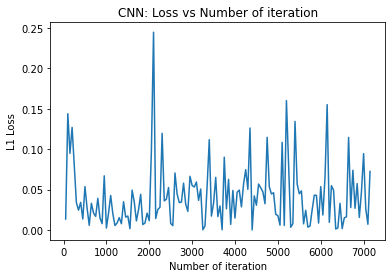

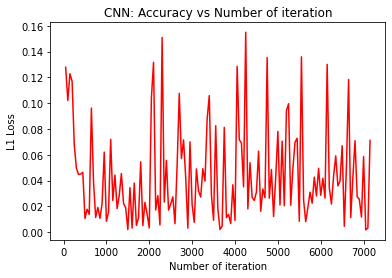

In [ ]:
# visualization loss
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("L1 Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("L1 Loss")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()

# Evaluate the model

In [ ]:
#To-do: evaluate on test set, instead of training set
random_image = random.randint(0,len(train_dataset))
image = train_dataset.__getitem__(random_image)
model.eval()
images, labels = next(iter(train_loader))
images, labels = images.to(device), labels.to(device)
predictions = torch.argmax(model(images),1)
num_cols=1
num_rows = 25# len(labels)
label_map = [['airplane'],['automobile'],['bird'],['cat'], ['deer'], ['dog'], ['frog'], ['horse'], ['ship'], ['truck']]

for idx in range(num_rows):
  img = images.cpu()[idx]
  
  plt.title(f"Label {label_map[labels[idx]]}, Prediction {label_map[predictions[idx]]}")  
  imshow(img)

  plt.axis('off')
plt.show()